In [1]:
import numpy as np
from scipy.io import loadmat, savemat
import os
from math import tan, radians, sqrt, atan, pi, cos, sin
from utils.visualizations import *
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.signal import find_peaks

In [3]:
# === Set thresholds for reciprocal pair constraints === #
pk_match_thresh = 100E-12 # set threshold for peak match constraint
path_diff_thresh = 100E-12 # set threshold for path diff match constraint

# === Data directory === #
exp_name = '/u/sidsoma/mirror_scanning_iccp24/experiments/mirror_test'
# exp_name = '/u/sidsoma/mirror_scanning_iccp24/experiments/diffuse_only_test'

# === Other parameters === #
c = 3E8 # speed of light

Text(0.5, 1.0, 'Projector Pattern')

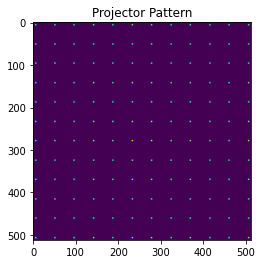

In [4]:
camera_params = loadmat(os.path.join(exp_name, 'params.mat'))

# === Load projector parameters === #
pixel_coords = camera_params['pixel_coords'] # in homogeneous coordinates
spot_hw = camera_params['spot_hw'][0][0]

# === Load Extrinsic parameters === #
camera_pos = camera_params['cam_pos'][0]
look_at = camera_params['look_pos'][0]
up_dir = camera_params['up_dir'][0]

# === Load Intrinsic parameters === #
fov = camera_params['fov'][0][0] # in degrees
x_res = camera_params['x_res'][0][0] # NOTE: CODE WILL ONLY WORK IF X_RES = Y_RES
y_res = camera_params['y_res'][0][0]

# === Load histogram parameters === #
hists_full = loadmat(os.path.join(exp_name, 'output.mat'))['I']
hists_full = hists_full[:, :, 0, :] # only use R channel out of RGB
numBins = hists_full.shape[-1]
tMin = camera_params['tMin'] / c
tMax = camera_params['tMax'] / c
tRes = camera_params['tRes'] / c

plt.imshow(camera_params['proj_img']); plt.title('Projector Pattern')

Text(0.5, 1.0, 'Pixel Integration Width')

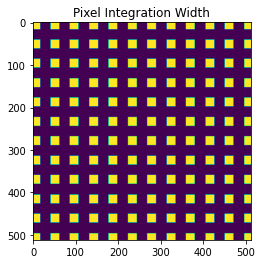

In [5]:
# === Increase pixel size by integrating histograms over neighboring pixels === #
hists = np.zeros((144, numBins))
int_proj_image = np.zeros((y_res, x_res))
int_width = 10
for i in range(144):
    idx_x = int(pixel_coords[i, 0])
    idx_y = int(pixel_coords[i, 1])
    # integrate histogram across neighboring pixels
    idx_1 = max(idx_y-int_width, 0)
    idx_2 = min(idx_y+int_width+1, y_res)
    idx_3 = max(idx_x-int_width, 0)
    idx_4 = min(idx_x+int_width+1, x_res)
    hists[i] = np.sum(hists_full[idx_1:idx_2, idx_3:idx_4], axis=(0, 1))
    int_proj_image[idx_1:idx_2, idx_3:idx_4] = 1

plt.imshow(int_proj_image); plt.title('Pixel Integration Width')

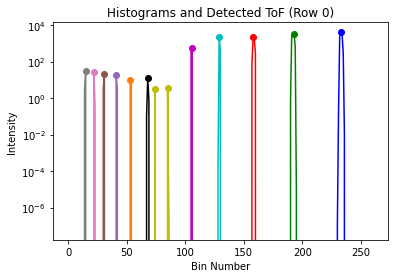

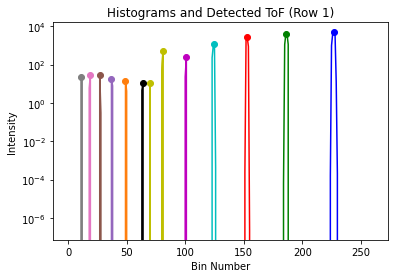

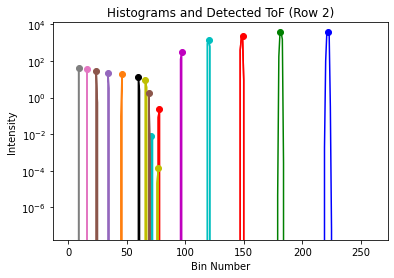

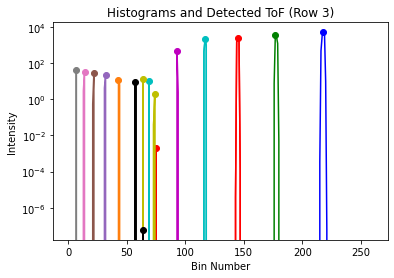

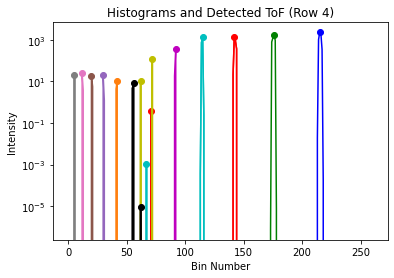

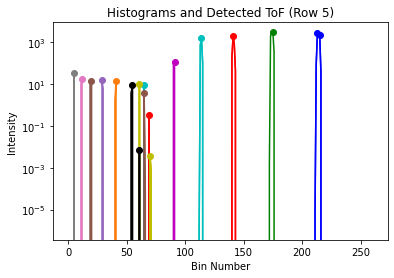

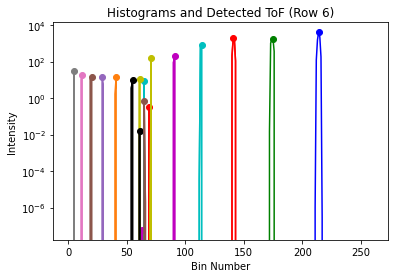

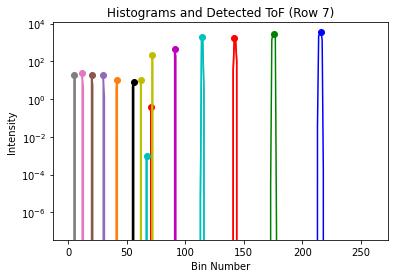

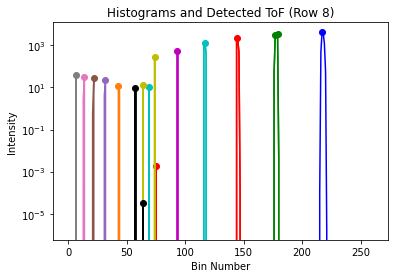

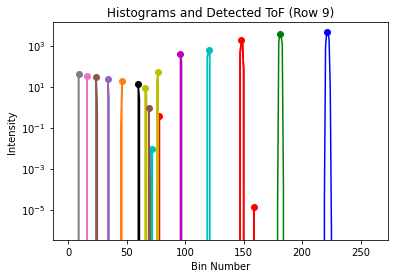

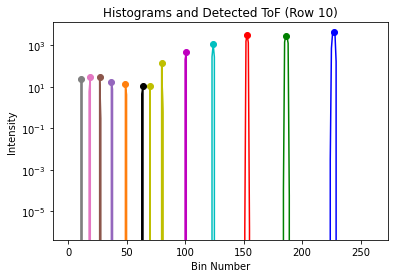

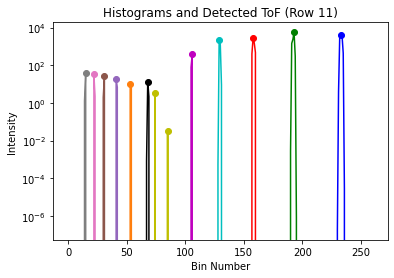

In [6]:
# === Extract echo 1 and echo 2 from histograms === #
#### CHECK PLOTS TO MAKE SURE THAT ECHOS ARE IN CORRECT LOCATION === #
def extract_echos(hists, tMin, tRes):
    # This function turns camera position / look at direction to extrinsic matrix
    # =========== INPUTS =========== #
    # histograms (N, T) --> N pixels, T timing bins
    # =========== OUTPUTS ========== #
    # echo 1 --> (N, 1), echo 2 --> (N, 1)

    numPixels = hists.shape[0]
    echo1 = np.zeros((numPixels, 1)); echo1[:] = np.nan
    echo2 = np.zeros((numPixels, 1)); echo2[:] = np.nan
    
    # === Extract per-pixel peaks === #
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']
    k = 0
    for i in range(12): # loop through every column
        plt.figure()
        plt.xlabel('Bin Number')
        plt.ylabel('Intensity')
        for j in range(12): # loop through every row
            peaks, _ = find_peaks(hists[k])
            # === Extract echo 1 and echo 2 (if available) === #
            if peaks.shape[0] == 1:
                echo1[k] = tMin + tRes * peaks[0]
            elif peaks.shape[0] >= 2: 
                echo1[k] = tMin + tRes * peaks[0]
                echo2[k] = tMin + tRes * peaks[1]

            # === Plot histograms and echos === #
            for p in peaks: # loop through every peak and plot
                plt.semilogy(hists[k, :], color=colors[j])
                plt.plot(p, hists[k, p], marker='o', color=colors[j])
                plt.title(f'Histograms and Detected ToF (Row {i})')
            k += 1

    # print(peaks)
    # echo1 = tMin + np.argmax(hists, axis=-1) * tRes
    # echo2 = echo1

    return echo1, echo2

echo_1, echo_2 = extract_echos(hists, tMin, tRes)

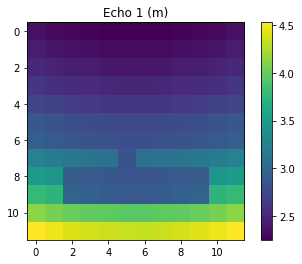

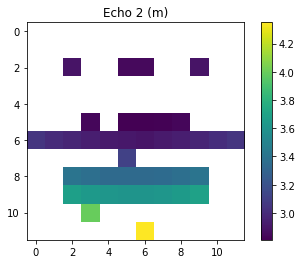

In [7]:
# === Visualize echo 1 and echo 2 === #
plt.figure(); plt.imshow(c*np.flip(echo_1.reshape(12, 12)).T, interpolation='none'); plt.title('Echo 1 (m)'); plt.colorbar()
plt.figure(); plt.imshow(c*np.flip(echo_2.reshape(12, 12)).T, interpolation='none'); plt.title('Echo 2 (m)'); plt.colorbar()

In [8]:
def extract_extrinsic_matrix(C, p, u):
    # This function turns camera position / look at direction to extrinsic matrix
    # Based on pseudo code from https://ksimek.github.io/2012/08/22/extrinsic/
    # =========== INPUTS =========== #
    # C = origin / camera center
    # p = look at point / target
    # u = up direction 
    # =========== OUTPUTS ========== #
    # camera matrix

    # Calculate the forward vector (the direction we're looking)
    forward = (p - C) / np.linalg.norm(p - C)

    # Calculate the right vector (perpendicular to the forward and up vectors)
    left = np.cross(u, forward)
    left = left / np.linalg.norm(left)

    # Calculate the up vector (perpendicular to the forward and right vectors)
    up = np.cross(forward, left)

    # Construct the rotation matrix
    cam2world = np.hstack([left.reshape(3, 1), up.reshape(3, 1), forward.reshape(3, 1), C.reshape(3, 1)])
    cam2world = np.vstack([cam2world, np.array([[0, 0, 0, 1]])])

    return cam2world

def extract_intrinsic_matrix(x_res, y_res, fov, fovAxis="x"):
    c_x = int(x_res/2) # in pixels
    c_y = int(y_res/2) # in pixels

    # === compute focal length === #
    f_x = x_res / (2*tan(radians(fov/2)))
    f_y = f_x

    intrinsic_matrix = np.array([[f_x,  0 , c_x, 0],
                                 [ 0 , f_y, c_y, 0],
                                 [ 0 ,  0 ,  1 , 0]])

    return intrinsic_matrix


In [9]:
# === Extract camera matrices === #
cam2world = extract_extrinsic_matrix(camera_pos, look_at, up_dir) # (4, 4) matrix ##### DOUBLE CHECK THIS FUNCTION
intrinsic_matrix = extract_intrinsic_matrix(x_res, y_res, fov) # (3, 3) matrix

# === Compute ray directions === #
pixel_coords_idx = deepcopy(pixel_coords)
pixel_coords_idx[:, 0:2] += 1

ray_cam_coords = np.linalg.inv(intrinsic_matrix[:, 0:3]) @ (pixel_coords_idx).T # (3, 3) * (3, 144) matrix
ray_cam_coords_hom = np.vstack([ray_cam_coords, np.ones((1, pixel_coords.shape[0]))]) # (4, 144) matrix

ray_dirs = cam2world @ ray_cam_coords_hom # (4, 144) matrix
ray_dirs = ray_dirs[0:3, :] / np.linalg.norm(ray_dirs[0:3, :], axis=0) # (3, 144) matrix
ray_dirs = ray_dirs.T # (144, 3) matrix

# === Visualize rays (for debugging) === #
debug = 0
if debug:
    rays_vis = create_ray_visualizer(ray_dirs)
    plot_rays_walls(rays_vis)
    plt.plot(pixel_coords[:, 0], pixel_coords[:, 1], 'o')

In [10]:
# === Estimate point cloud from echos and camera rays (debug for sanity check) === # 
if debug:
    pt_cloud = ray_dirs * (c * echo_1 / 2)
    plot_point_cloud([pt_cloud], camera_pos)

    # sanity check 
    wall_distance = 1
    print("NOTE: These values assume that the camera is perpendicular to the wall.")
    print("Measured Wall Width: ", np.max(pt_cloud[:, 0]) - np.min(pt_cloud[:, 0]))
    print("Expected Wall Width: ", 2 * tan(radians(fov/2)))

    print("Measured Wall Distance: ", np.mean(pt_cloud[:, 2]))
    print("Expected Wall Distance: ", wall_distance)


In [11]:
class Ellipse:
    def __init__(self, tof, x_illum, camera_params):
        """
        INPUTS:
            tof = total 2B tof
            x_c = camera_location (focus 1)
            x_illum = laser illumination point (focus 2)
            camera_params = camera/laser location
        """
        # === Ellipse Parameters === #
        # Focus vectors and length
        self.f_1 = camera_params.x_c # focus 1
        self.f_2 = x_illum # focus 2
        self.f_vec = (self.f_2 - self.f_1) / 2
        self.f = np.linalg.norm(self.f_vec) # focus length

        # Major and Minor axis
        self.a = (c*tof - np.linalg.norm(x_illum - camera_params.x_l)) / 2 # major axis
        self.skip = True
        if self.a**2 - self.f**2 > 0:
            self.b = sqrt(self.a**2 - self.f**2) # minor axis

            # === Compute Transformations Parameters === #
            self.center = (self.f_1 + self.f_2) / 2
            self.t_xz = atan(abs(self.f_vec[2] / self.f_vec[0])) # NOTE: Assumes z > 0
            if self.f_vec[0] < 0:
                self.t_xz = pi - self.t_xz
            new_x_mag = np.linalg.norm([self.f_vec[0], self.f_vec[2]])
            self.t_xy = -atan(self.f_vec[1] / new_x_mag)

            # === Compute Unit Sphere Transformation Matrix === #
            # Rotation matrices
            rot_xz = np.array([[cos(self.t_xz) , 0, sin(self.t_xz)],
                               [      0        , 1,        0      ],
                               [-sin(self.t_xz), 0, cos(self.t_xz)]])
            rot_xy = np.array([[cos(self.t_xy), -sin(self.t_xy), 0],
                               [sin(self.t_xy),  cos(self.t_xy), 0],
                               [       0      ,        0       , 1]])

            # Scaling matrix
            scale_matrix = np.array([[(1/self.a),      0    ,     0     ],
                                     [  0       , (1/self.b),     0     ],
                                     [  0       ,      0    , (1/self.b)]])
            self.T = scale_matrix @ rot_xy @ rot_xz
            self.skip = False
    
    def compute_ray_ellipse_intersection(self, ray):
            if abs(np.linalg.norm(ray) - 1.0) > 1E-5:
                raise AssertionError("Input rays should be normalized to unit length")
            rho = self.compute_rho(ray)
            return rho * ray

    def compute_rho(self, x_dir):
        m1 = self.T @ x_dir
        m2 = self.T @ self.center
        a = np.linalg.norm(m1)**2
        b = -2*np.dot(m1, m2)
        c = np.linalg.norm(m2)**2 - 1
        return (-b + sqrt(b**2-4*a*c)) / (2*a) 
class Camera:
    def __init__(self, x_c, x_l):
        self.x_c = x_c
        self.x_l = x_l

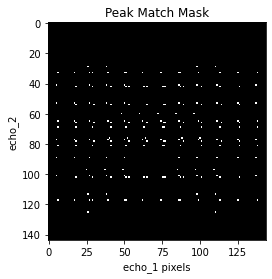

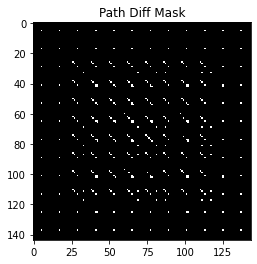

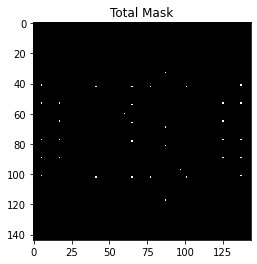

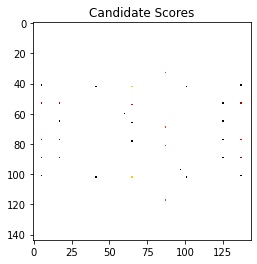

In [12]:
# =================== STEP 1: IDENTIFY RECIPROCAL PAIRS =================== #
def detect_reciprocal_pairs(echo_1, echo_2):

    ########################### INPUTS ###########################
    # echo_1 : (144 x 1) vector of per-pixel time-of-flight of first echo [seconds]
    # echo_2 : (144 x 1) vector of per-pixel time-of-flight of second echo [seconds]

    ########################### OUTPUT ###########################
    # reciprocal_pairs : (K x 2) array of reciprocal indices
    #     * Kth row contains the indices of the two pixels that are reciprocal pairs

    # === Check peak match constraint === #
    pk_match_test = np.abs(echo_2 - echo_1.T)
    pk_match_test = np.nan_to_num(pk_match_test, nan=10000)
    pk_match_mask = (np.abs(pk_match_test) < pk_match_thresh)
    plt.figure(); 
    # plt.imshow(pk_match_test, interpolation='none')
    plt.imshow(pk_match_mask, cmap='gray', interpolation='none')
    plt.title('Peak Match Mask'); plt.ylabel('echo_2'); plt.xlabel('echo_1 pixels')

    # === Check path diff match constraint === #
    echo_diff = echo_2 - echo_1
    path_diff_test = np.abs(echo_diff - echo_diff.T)
    path_diff_test = np.nan_to_num(path_diff_test, nan=10000)
    path_diff_mask = (path_diff_test < path_diff_thresh)
    plt.figure(); 
    # plt.imshow(path_diff_test, interpolation='none')
    plt.imshow(path_diff_mask, cmap='gray', interpolation='none')
    plt.title('Path Diff Mask')

    # === Combine two constraints === #
    total_mask = pk_match_mask * path_diff_mask
    plt.figure(); 
    plt.imshow(total_mask, cmap='gray', interpolation='none')
    plt.title('Total Mask')

    # === Remove multiple redundant candidate pairs === #
    candidate_scores = pk_match_test * path_diff_test
    # set masked pixels to be infinity
    remove_candidates = np.where(1-total_mask) 
    candidate_scores[remove_candidates] = np.inf
    plt.figure(); 
    plt.imshow(candidate_scores, cmap='hot', interpolation='none')
    plt.title('Candidate Scores')

    # find min only along qualified points 
    reciprocal_pairs = []
    for i in range(144):
        if np.sum(total_mask[i]) == 0:
            continue
        idx = np.argmin(candidate_scores[i])
        reciprocal_pairs.append(np.array([i, idx]))

    return np.array(reciprocal_pairs)

reciprocal_pairs = detect_reciprocal_pairs(echo_1, echo_2)


In [13]:
# =================== STEP 2: RECONSTRUCTION FROM RECIPROCAL PAIRS =================== #
num_pairs = reciprocal_pairs.shape[0]
diffuse_pt_cloud = np.zeros((num_pairs, 3))
specular_pt_cloud = np.zeros((num_pairs, 3))
for i in range(num_pairs):
    pixel_A = reciprocal_pairs[i][0]
    pixel_B = reciprocal_pairs[i][1]

    # === Determine which pixel is specular and diffuse === #
    if echo_1[pixel_A] > echo_1[pixel_B]:
        diffuse_pt = pixel_A
        specular_pt = pixel_B
    else:
        diffuse_pt = pixel_B
        specular_pt = pixel_A

    # === Locate diffuse point === #
    diffuse_x = c * (echo_1[diffuse_pt] / 2) * ray_dirs[diffuse_pt] # first return from specular pt is 1-bounce
    diffuse_pt_cloud[i] = diffuse_x

    # === Locate specular point === #
    camera_params = Camera(camera_pos, camera_pos)
    ellipse_data = Ellipse(echo_2[specular_pt], diffuse_x, camera_params) # first return from specular pt is 2-bounce
    if ellipse_data.skip:
        continue
    specular_pt_cloud[i] = ellipse_data.compute_ray_ellipse_intersection(ray_dirs[specular_pt])

/tmp/ipykernel_1379214/3138224011.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scale_matrix = np.array([[(1/self.a),      0    ,     0     ],


In [17]:
plot_point_cloud([diffuse_pt_cloud, specular_pt_cloud], camera_pos)

In [14]:
diffuse_pt_cloud

array([[ 0.12393386, -1.14418484,  0.8571502 ],
       [-0.44281933, -1.01844282,  0.96311228],
       [-0.20151885, -1.02128432,  0.9657994 ],
       [ 0.36498505, -1.01960192,  0.9642084 ],
       [-0.03920096, -1.0204306 ,  0.96499206],
       [-0.05762228, -1.92036693,  0.99804585],
       [-0.36331667, -1.01991642,  0.96450582],
       [-0.03920096, -1.0204306 ,  0.96499206],
       [ 0.12393386, -1.14418484,  0.8571502 ],
       [ 0.36498505, -1.01960192,  0.9642084 ],
       [-0.03920096, -1.0204306 ,  0.96499206],
       [ 0.12393386, -1.14418484,  0.8571502 ],
       [ 0.36498505, -1.01960192,  0.9642084 ],
       [ 0.27535435, -1.69408143,  0.99724274],
       [-0.44281933, -1.01844282,  0.96311228],
       [-0.20151885, -1.02128432,  0.9657994 ],
       [ 0.12393386, -1.14418484,  0.8571502 ]])

In [15]:
specular_pt_cloud

array([[-3.54485843e-02, -9.89847418e-02,  1.49431905e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.43078241e-02, -2.04713553e-01,  1.93591759e-01],
       [-8.26937002e-02, -6.57727176e-01,  6.97282627e-01],
       [-5.78884385e-02, -1.92923699e+00,  1.00265576e+00],
       [-5.09305056e-16, -1.32575944e-14,  1.25373283e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.09969656e-03, -2.26573178e-01,  2.14263782e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.33386628e-02, -5.25689403e-01,  4.97129450e-01],
       [ 2.76741524e-01, -1.70261585e+00,  1.00226664e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.11643545e-02, -1.41975694e-01